## fix random seed for reproducibility

In [391]:
import random
import numpy as np
import torch
import random
import torch.backends.cudnn as cudnn

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # slightly slower but reproducible

set_seed(24)

## loading dataset

In [392]:
from datasets import load_dataset

ds = load_dataset("surrey-nlp/PLOD-CW-25")

In [393]:
train_data = ds['train']
test_data = ds['test']
validate_data = ds['validation']

## general preprocessing

In [394]:
all_tokens = set([token for sent in train_data['tokens'] for token in sent])
ner_tags = set([tag for sent in train_data['ner_tags'] for tag in sent])

In [395]:
from collections import Counter

tokens_train = [ex['tokens'] for ex in ds['train']]

word_counter = Counter(token for sent in tokens_train for token in sent)

# Assign unique indices
word_vocab = {token: idx + 2 for idx, (token, _) in enumerate(word_counter.items())}
# equivilent to: token to id
word_vocab['<PAD>'] = 0
word_vocab['<UNK>'] = 1

In [396]:
def token_to_id_fn(token, token_to_id):
    return token_to_id.get(token, token_to_id['<UNK>'])

def id_to_token_fn(idx, id_to_token):
    return id_to_token.get(idx, '<UNK>')

def tag_to_id_fn(tag, tag_to_id):
    return tag_to_id[tag]

def id_to_tag_fn(idx, id_to_tag):
    return id_to_tag.get(idx, 'O')

In [397]:
def map_dataset(dataset, token_to_id, tag_to_id):
  mapped_dataset = []
  for row in dataset:
    tokens = row['tokens']
    ner_tags = row['ner_tags']
    mapped_tokens = [token_to_id.get(token, token_to_id['<UNK>']) for token in tokens]
    mapped_ner_tags = [tag_to_id[tag] for tag in ner_tags]
    mapped_dataset.append({
        'tokens': mapped_tokens,
        'ner_tags': mapped_ner_tags
    })
  return mapped_dataset

In [398]:
tag_to_id = {
    'O': 0,
    'B-LF': 1,
    'I-LF': 2,
    'B-AC': 3
}

In [399]:
mapped_train_data = map_dataset(train_data, word_vocab, tag_to_id)
mapped_test_data = map_dataset(test_data, word_vocab, tag_to_id)
mapped_validate_data = map_dataset(validate_data, word_vocab, tag_to_id)

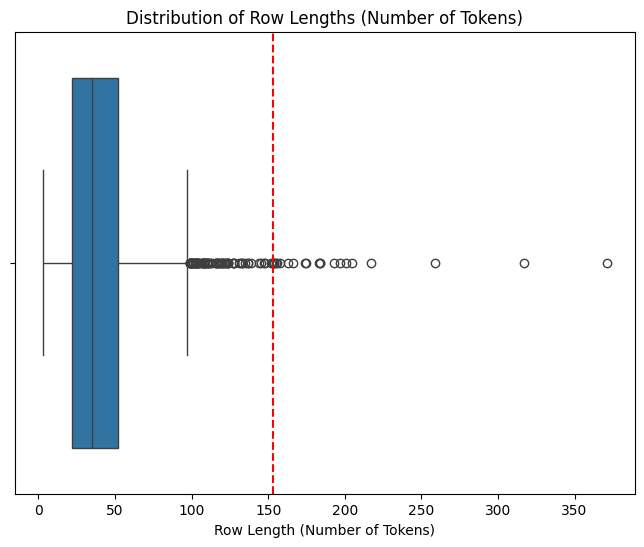

In [400]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

row_lengths = [len(sent['tokens']) for sent in mapped_train_data]


percentile = np.percentile(row_lengths, 99)
plt.figure(figsize=(8, 6))
sns.boxplot(x=row_lengths)
plt.axvline(x=np.percentile(row_lengths, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of Row Lengths (Number of Tokens)")
plt.xlabel("Row Length (Number of Tokens)")
plt.show()

In [401]:
MAX_LENGTH = 150

def pad_dataset(dataset, max_length):
    padded_dataset = []
    for row in dataset:
        tokens = row['tokens']
        ner_tags = row['ner_tags']
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
            ner_tags = ner_tags[:max_length]

        else:
            tokens += [0] * (max_length - len(tokens))
            ner_tags += [0] * (max_length - len(ner_tags))

        mask = [1 if token != 0 else 0 for token in tokens]

        padded_dataset.append({
            'tokens': tokens,
            'ner_tags': ner_tags,
            'mask': mask
        })

    return padded_dataset

In [402]:
padded_train_data = pad_dataset(mapped_train_data, MAX_LENGTH)
padded_test_data = pad_dataset(mapped_test_data, MAX_LENGTH)
padded_validate_data = pad_dataset(mapped_validate_data, MAX_LENGTH)

In [403]:
VOCAB_SIZE = len(word_vocab)
DIM = 100

## embedding

In [404]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_path = "bio_embedding_extrinsic"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [405]:
# checking vector size
print(f"Embedding vector size: {w2v_model.vector_size}")

# checking vocabulary size
print(f"Vocabulary size: {len(w2v_model.key_to_index)} words")

Embedding vector size: 200
Vocabulary size: 2324849 words


In [406]:
import numpy as np

# setting up embedding matrix
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word_vocab), embedding_dim))


# fill the matrix
for word, idx in word_vocab.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [407]:
# 1. Check dimensions
print(f"Embedding matrix shape: {embedding_matrix.shape}")
assert embedding_matrix.shape[0] == len(word_vocab), "Mismatch in vocab size!"
assert embedding_matrix.shape[1] == w2v_model.vector_size, "Mismatch in embedding dim!"

# 2. Check OOV (out of vocab) words
covered = sum(1 for word in word_vocab if word in w2v_model)
total = len(word_vocab)
print(f"Coverage: {covered}/{total} words ({covered/total*100:.2f}%)")

# 3. Sample vector check
sample_word = 'glucose'
if sample_word in word_vocab:
    idx = word_vocab[sample_word]
    print(f"Sample vector for '{sample_word}': {embedding_matrix[idx][:10]}")
else:
    print(f"'{sample_word}' not found in word_vocab")

Embedding matrix shape: (14742, 200)
Coverage: 7463/14742 words (50.62%)
Sample vector for 'glucose': [ 0.30148456  0.06259853  0.06257256  0.02667626 -0.30542654  0.30082998
 -0.14734118 -0.20231321  0.28477651 -0.29688197]


In [408]:
# List out OOV words
oov_words = [word for word in word_vocab if word not in w2v_model]

# Show a few (first 20)
print(f"Total OOV words: {len(oov_words)} / {len(word_vocab)}")
print("Sample OOV words:")
for i, word in enumerate(oov_words[:20]):
    print(f"{i+1:2d}. {word}")

Total OOV words: 7279 / 14742
Sample OOV words:
 1. MRR
 2. ,
 3. ;
 4. TBI
 5. .
 6. HPC
 7. mOFC
 8. OFC
 9. PPI
10. In
11. 18β
12. GA
13. (
14. AQP-3
15. )
16. Abbreviations
17. :
18. HC
19. C
20. KD


In [409]:
# Assuming you have a `word_counter` (e.g., from collections.Counter)
from collections import Counter

# Build a frequency dict of just the OOV words
oov_freq = {word: word_counter[word] for word in oov_words if word in word_counter}

# Sort by frequency
top_oov = sorted(oov_freq.items(), key=lambda x: -x[1])[:20]

# Print top frequent OOVs
print(" Top Frequent OOV Words:")
for word, freq in top_oov:
    print(f"{word:15s} → {freq}")


 Top Frequent OOV Words:
,               → 5206
(               → 2965
)               → 2930
.               → 2321
;               → 1989
]               → 640
[               → 620
:               → 405
The             → 315
/               → 286
=               → 260
%               → 225
–               → 151
C               → 145
Fig             → 117
A               → 115
We              → 107
CI              → 103
In              → 100
RNA             → 81


In [410]:
# Let's inspect a few known biomedical words in the pretrained embedding model
# We will look for both cased and lowercased versions

words_to_check = ["Glucose", "glucose", "Insulin", "insulin", "COVID", "covid"]
availability = {word: word in w2v_model for word in words_to_check}
availability

{'Glucose': False,
 'glucose': True,
 'Insulin': False,
 'insulin': True,
 'COVID': False,
 'covid': False}

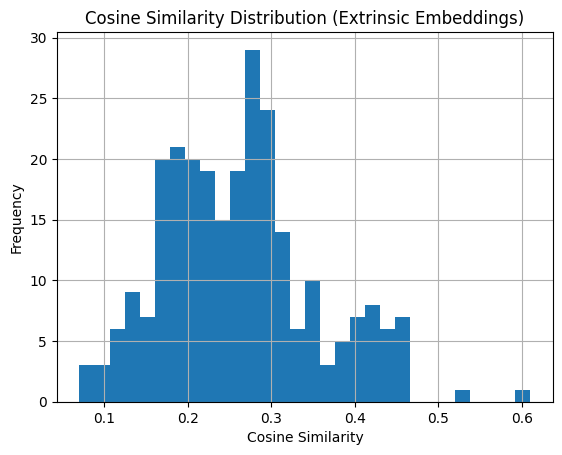

In [411]:
import random
import matplotlib.pyplot as plt

# Sample random word pairs
words = random.sample(list(word_vocab.keys()), 1000)
similarities = []
for i in range(len(words)-1):
    w1, w2 = words[i], words[i+1]
    if w1 in w2v_model and w2 in w2v_model:
        sim = w2v_model.similarity(w1, w2)
        similarities.append(sim)

# Plot
plt.hist(similarities, bins=30)
plt.title("Cosine Similarity Distribution (Extrinsic Embeddings)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [412]:
w2v_model.most_similar('glucose', topn=5)

[('qglucose', 0.8199415802955627),
 ('rglucose', 0.8195745944976807),
 ('glucose-time', 0.8183287978172302),
 ('iv-glucose', 0.8175548315048218),
 ('cglucose', 0.8104894757270813)]

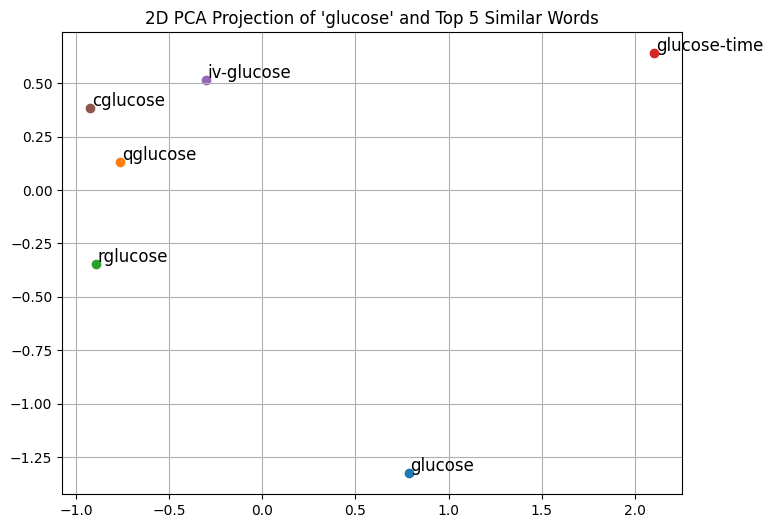

In [413]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get top 5 most similar words
word = 'glucose'
topn = 5
similar_words = w2v_model.most_similar(word, topn=topn)

# Collect word vectors
words = [word] + [w for w, _ in similar_words]  # include 'glucose' itself
vectors = [w2v_model[w] for w in words]

# Reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(words):
    x, y = reduced_vectors[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=12)

plt.title(f"2D PCA Projection of '{word}' and Top {topn} Similar Words")
plt.grid(True)
plt.show()


In [414]:
import torch.nn as nn
class PretrainedWordEmbedding(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.output_dim = embedding_matrix.shape[1]

    def forward(self, word_ids, char_ids=None):
        return self.word_embedding(word_ids)


## combined words and char embeddings with ngram

In [415]:
import torch
import torch.nn as nn

word_embedding = nn.Embedding(VOCAB_SIZE, DIM)

In [416]:
chars = set([c for token in all_tokens for c in token])
char_to_id = {char: idx + 2 for idx, char in enumerate(chars)}
char_to_id['<PAD>'] = 0
char_to_id['<UNK>'] = 1

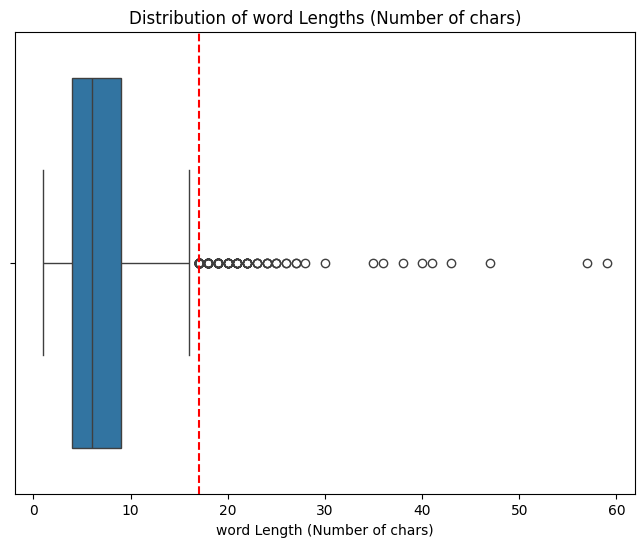

In [417]:
word_lengths = [len(w) for w in all_tokens]

plt.figure(figsize=(8, 6))
sns.boxplot(x=word_lengths)
plt.axvline(x=np.percentile(word_lengths, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of word Lengths (Number of chars)")
plt.xlabel("word Length (Number of chars)")
plt.show()

In [418]:
MAX_LENGTH_WORD = 15

In [419]:
def word_to_char_ids(word, char_to_id):
    char_ids = [char_to_id.get(c, char_to_id['<UNK>']) for c in word]
    char_ids = char_ids[:MAX_LENGTH_WORD]
    char_ids += [char_to_id['<PAD>']] * (MAX_LENGTH_WORD - len(char_ids))
    return char_ids

In [420]:
def convert_tokens_to_char_ids(dataset, id_to_token_fn, char_to_id, token_to_id): # Added token_to_id as argument
    """Convert token IDs in a dataset to lists of character IDs per token."""
    updated_dataset = []

    # Create the id_to_token dictionary using token_to_id
    id_to_token = {v: k for k, v in token_to_id.items()} # Create the id_to_token dictionary

    for row in dataset:
        token_ids = row['tokens']
        char_id_seqs = []

        for token_id in token_ids:
            token = id_to_token.get(token_id, '<UNK>')
            char_ids = word_to_char_ids(token, char_to_id)
            char_id_seqs.append(char_ids)

        updated_dataset.append({
            'tokens': char_id_seqs,
            'ner_tags': row['ner_tags']
        })

    return updated_dataset

train_char_dataset = convert_tokens_to_char_ids(padded_train_data, id_to_token_fn, char_to_id, word_vocab)
test_char_dataset = convert_tokens_to_char_ids(padded_test_data, id_to_token_fn, char_to_id, word_vocab)
validate_char_dataset = convert_tokens_to_char_ids(padded_validate_data, id_to_token_fn, char_to_id, word_vocab)

In [421]:
class WordAndCharEmbedding(nn.Module):
    def __init__(self, word_vocab_size, word_embedding_dim, char_vocab_size, char_embedding_dim, hidden_dim):
        super().__init__()

        # word-level embedding
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim, padding_idx=0)

        # char-level embedding
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim, padding_idx=0)
        self.char_lstm = nn.LSTM(char_embedding_dim, hidden_dim // 2, bidirectional=True, batch_first=True, num_layers=1)

        self.dropout = nn.Dropout(0.5)
        self.output_dim = word_embedding_dim + hidden_dim

    def forward(self, word_ids, char_ids):
        batch_size, seq_len, max_word_len = char_ids.size()

        word_emb = self.word_embedding(word_ids)                          # [B, L, D_word]
        char_ids = char_ids.view(-1, max_word_len)                        # [B*L, max_len]
        char_emb = self.char_embedding(char_ids)                          # [B*L, max_len, D_char]

        _, (hidden, _) = self.char_lstm(char_emb)                         # hidden: [2, B*L, H/2]
        char_repr = torch.cat([hidden[0], hidden[1]], dim=-1)             # [B*L, H]
        char_repr = char_repr.view(batch_size, seq_len, -1)               # [B, L, H]

        combined = torch.cat([word_emb, char_repr], dim=-1)               # [B, L, D_word + H]
        return self.dropout(combined)


In [422]:
word_char_embedding = WordAndCharEmbedding(
    word_vocab_size=VOCAB_SIZE,
    word_embedding_dim=DIM,  # Word embedding dimension
    char_vocab_size=len(char_to_id),
    char_embedding_dim=50,  # Character embedding dimension
    hidden_dim=100           # Hidden dimension for char-level LSTM
)

embedding_dim = DIM + 100


In [423]:
word_ids = torch.randint(0, len(word_vocab), (32, 50))
char_ids = torch.randint(0, len(char_to_id), (32, 50, 12))

combined = word_char_embedding(word_ids, char_ids)
print(combined.shape)

torch.Size([32, 50, 200])


## define model (crf + biLSTM)

In [424]:
import torch
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_labels):
        super().__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(self.embedding.output_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, word_ids, char_ids=None, labels=None, mask=None):
        if char_ids is not None:
            embeddings = self.embedding(word_ids, char_ids)
        else:
            embeddings = self.embedding(word_ids)
        lstm_out, _ = self.lstm(embeddings)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            return -self.crf(emissions, labels, mask=mask, reduction='mean')
        else:
            return self.crf.decode(emissions, mask=mask)


In [425]:
class NERDataset(Dataset):
    def __init__(self, word_data, char_data=None):
        self.word_data = word_data
        self.char_data = char_data

    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        word_item = self.word_data[idx]
        tokens = torch.tensor(word_item['tokens'], dtype=torch.long)
        ner_tags = torch.tensor(word_item['ner_tags'], dtype=torch.long)
        mask = torch.tensor(word_item['mask'], dtype=torch.bool)

        if self.char_data is not None:
            char_item = self.char_data[idx]
            char_ids = torch.tensor(char_item['tokens'], dtype=torch.long)
            return tokens, char_ids, ner_tags, mask
        else:
            return tokens, ner_tags, mask

In [426]:
train_dataset = NERDataset(padded_train_data, train_char_dataset)
test_dataset = NERDataset(padded_test_data, test_char_dataset)
validate_dataset = NERDataset(padded_validate_data, validate_char_dataset)

In [427]:
def collate_fn(batch):
    if len(batch[0]) == 4:
        tokens, char_ids, ner_tags, masks = zip(*batch)
        return (
            torch.stack(tokens),
            torch.stack(char_ids),
            torch.stack(ner_tags),
            torch.stack(masks)
        )
    else:
        tokens, ner_tags, masks = zip(*batch)
        return (
            torch.stack(tokens),
            torch.stack(ner_tags),
            torch.stack(masks)
        )


## training and evaluation

In [428]:
# Hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [429]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_model(model, dataloader, id_to_tag=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                predictions = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                predictions = model(tokens, mask=mask)

            for pred_seq, true_seq, m in zip(predictions, tags, mask):
                seq_len = m.sum().item()
                pred = pred_seq[:seq_len]
                true = true_seq[:seq_len].tolist()

                all_preds.extend(pred)
                all_labels.extend(true)

    model.train()

    f1 =  f1_score(all_labels, all_preds, average="macro")

    return f1


In [430]:
import torch

def train_model(
    model,
    train_loader,
    optimizer,
    num_epochs=5,
    val_loader=None,
    id_to_tag=None,
    save_path="best_model.pt"
):
    best_f1 = -1.0
    train_loss = []
    f1_scores = []
    for epoch in range(num_epochs):
        
        model.train()
        total_loss = 0

        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                loss = model(tokens, char_ids=char_ids, labels=tags, mask=mask)
            else:
                tokens, tags, mask = batch
                loss = model(tokens, labels=tags, mask=mask)

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Training Loss: {total_loss:.4f}")

        if val_loader is not None and id_to_tag is not None:
            f1_score = evaluate_model(model, val_loader, id_to_tag)
            f1_scores.append(f1_score)
            print(f"f1 score  - {f1_score}")

            # Save best model by F1
            if f1_score > best_f1:
                best_f1 = f1_score
                torch.save(model.state_dict(), save_path)
                print(f"Best model updated and saved to: {save_path}")
    return train_loss, f1_scores


In [431]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [432]:
NUM_EPOCHS = 10

In [433]:
from torch.optim import Adam

w2v_embedding = PretrainedWordEmbedding(embedding_matrix)


model_w2v = BiLSTM_CRF(
    embedding_layer=w2v_embedding,
    hidden_dim=256,
    num_labels=len(tag_to_id)
)
with torch.no_grad():
    model_w2v.crf.start_transitions[tag_to_id['B-AC']] -= 2.0
    model_w2v.crf.transitions[tag_to_id['O'], tag_to_id['I-LF']] -= 2.0
    model_w2v.crf.transitions[tag_to_id['I-LF'], tag_to_id['B-AC']] -= 2.0


optimizer_w2v = Adam(model_w2v.parameters(), lr=0.001)


w2v_loss, w2v_f1 = train_model(model_w2v, train_loader, optimizer_w2v, num_epochs=NUM_EPOCHS, val_loader=validate_loader, id_to_tag=tag_to_id, save_path="w2v_model.pt")
# Load the best model
model_w2v.load_state_dict(torch.load("w2v_model.pt"))


Epoch 1, Training Loss: 1511.4813
f1 score  - 0.6478433215031135
Best model updated and saved to: w2v_model.pt
Epoch 2, Training Loss: 767.3335
f1 score  - 0.7286098607530859
Best model updated and saved to: w2v_model.pt
Epoch 3, Training Loss: 560.9699
f1 score  - 0.7330582621940266
Best model updated and saved to: w2v_model.pt
Epoch 4, Training Loss: 427.1911
f1 score  - 0.7608214696286343
Best model updated and saved to: w2v_model.pt
Epoch 5, Training Loss: 326.9213
f1 score  - 0.7573867965479752
Epoch 6, Training Loss: 246.1382
f1 score  - 0.7576781393458996
Epoch 7, Training Loss: 174.1904
f1 score  - 0.7501874257908294
Epoch 8, Training Loss: 125.3383
f1 score  - 0.7337810422352326
Epoch 9, Training Loss: 89.6450
f1 score  - 0.7115414928928943
Epoch 10, Training Loss: 61.7840
f1 score  - 0.7251252064570106


<All keys matched successfully>

In [434]:
combined_embedding = WordAndCharEmbedding(
    word_vocab_size=VOCAB_SIZE,           # size of your word_vocab
    word_embedding_dim=DIM,               # e.g. 100
    char_vocab_size=len(char_to_id),      # size of your char vocab
    char_embedding_dim=50,                # dimension of character embeddings
    hidden_dim=100                        # hidden size for char-level BiLSTM
)

model_combined = BiLSTM_CRF(
    embedding_layer=combined_embedding,
    hidden_dim=256,                       # hidden size for main BiLSTM
    num_labels=len(tag_to_id)            # number of NER classes
)
with torch.no_grad():
    model_combined.crf.start_transitions[tag_to_id['B-AC']] -= 2.0
    model_combined.crf.transitions[tag_to_id['O'], tag_to_id['I-LF']] -= 2.0
    model_combined.crf.transitions[tag_to_id['I-LF'], tag_to_id['B-AC']] -= 2.0


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn                 # the flexible collate_fn we discussed
)

optimizer_combined = Adam(model_combined.parameters(), lr=0.001)


combined_loss, combined_f1 = train_model(model_combined, train_loader, optimizer_combined, num_epochs=NUM_EPOCHS, val_loader=validate_loader, id_to_tag=tag_to_id, save_path="combined_model.pt")
# Load the best model
model_combined.load_state_dict(torch.load("combined_model.pt"))


Epoch 1, Training Loss: 1723.1754
f1 score  - 0.5288646846239614
Best model updated and saved to: combined_model.pt
Epoch 2, Training Loss: 835.2357
f1 score  - 0.7197700874383142
Best model updated and saved to: combined_model.pt
Epoch 3, Training Loss: 622.7380
f1 score  - 0.7321400655401938
Best model updated and saved to: combined_model.pt
Epoch 4, Training Loss: 545.1897
f1 score  - 0.7539335464469811
Best model updated and saved to: combined_model.pt
Epoch 5, Training Loss: 502.3943
f1 score  - 0.7524084162268061
Epoch 6, Training Loss: 458.5955
f1 score  - 0.7630212544713364
Best model updated and saved to: combined_model.pt
Epoch 7, Training Loss: 427.7698
f1 score  - 0.7650615211179215
Best model updated and saved to: combined_model.pt
Epoch 8, Training Loss: 394.0697
f1 score  - 0.7664070116810895
Best model updated and saved to: combined_model.pt
Epoch 9, Training Loss: 371.2646
f1 score  - 0.7678675774563569
Best model updated and saved to: combined_model.pt
Epoch 10, Train

<All keys matched successfully>

In [435]:
id2tag = {v: k for k, v in tag_to_id.items()}

In [436]:
from seqeval.metrics import classification_report

def evaluate_seqeval(model, dataloader, tag_to_id):
    id2tag = {v: k for k, v in tag_to_id.items()}
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                preds = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                preds = model(tokens, mask=mask)

            for pred_seq, true_seq, m in zip(preds, tags, mask):
                seq_len = m.sum().item()
                pred_tags = [id2tag[p] for p in pred_seq[:seq_len]]
                true_tags = [id2tag[t.item()] for t in true_seq[:seq_len]]

                all_preds.append(pred_tags)
                all_labels.append(true_tags)

    model.train()
    print(classification_report(all_labels, all_preds))


In [437]:

print("Evaluation for Word2Vec embedding:")
evaluate_seqeval(model_w2v, test_loader, tag_to_id)


print("Evaluation for Word+Char embedding:")
evaluate_seqeval(model_combined, test_loader, tag_to_id)


Evaluation for Word2Vec embedding:
              precision    recall  f1-score   support

          AC       0.82      0.68      0.74       793
          LF       0.68      0.70      0.69       481

   micro avg       0.76      0.69      0.72      1274
   macro avg       0.75      0.69      0.72      1274
weighted avg       0.77      0.69      0.72      1274

Evaluation for Word+Char embedding:
              precision    recall  f1-score   support

          AC       0.73      0.80      0.77       793
          LF       0.68      0.68      0.68       481

   micro avg       0.71      0.76      0.73      1274
   macro avg       0.71      0.74      0.72      1274
weighted avg       0.71      0.76      0.73      1274



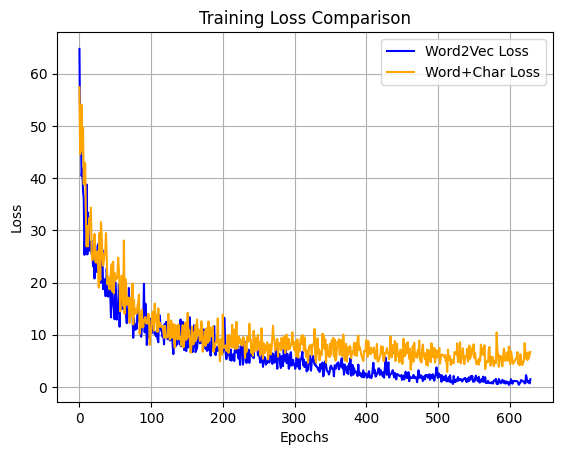

In [438]:
# digram to compare two models training loss
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.plot(w2v_loss, label='Word2Vec Loss', color='blue')
plt.plot(combined_loss, label='Word+Char Loss', color='orange')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

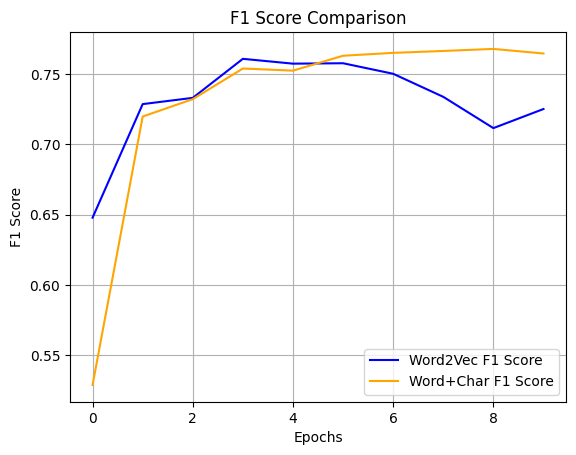

In [439]:
# digram to compare two models f1 score
plt.plot(w2v_f1, label='Word2Vec F1 Score', color='blue')
plt.plot(combined_f1, label='Word+Char F1 Score', color='orange')
plt.title('F1 Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

## error analysis

In [440]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_ner_confusion_data(predictions, tag_list):
    all_preds, all_trues = [], []
    for _, preds, trues in predictions:
        for p, t in zip(preds, trues):
            all_preds.append(p)
            all_trues.append(t)

    cm = confusion_matrix(all_trues, all_preds, labels=tag_list, normalize='true')
    return cm


In [441]:
from sklearn.metrics import ConfusionMatrixDisplay
def compare_ner_confusion_matrices(predictions_1, predictions_2, tag_list, labels=("Model 1", "Model 2")):
    cm1 = get_ner_confusion_data(predictions_1, tag_list)
    cm2 = get_ner_confusion_data(predictions_2, tag_list)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for ax, cm, label in zip(axes, [cm1, cm2], labels):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_list)
        disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
        ax.set_title(f"Confusion Matrix: {label}")
        ax.grid(False)

    plt.tight_layout()
    plt.show()


In [442]:
def collect_predictions(model, dataloader, id_to_tag, id_to_word=None, device='cpu'):
    model.eval()
    all_examples = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                tokens, char_ids, tags, mask = map(lambda x: x.to(device), (tokens, char_ids, tags, mask))
                preds = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                tokens, tags, mask = map(lambda x: x.to(device), (tokens, tags, mask))
                preds = model(tokens, mask=mask)

            for tok_ids, pred_seq, true_seq, m in zip(tokens, preds, tags, mask):
                seq_len = int(m.sum().item())
                pred_tags = [id_to_tag[p] for p in pred_seq[:seq_len]]
                true_tags = [id_to_tag[t.item()] for t in true_seq[:seq_len]]

                if id_to_word is not None:
                    words = [id_to_word[t.item()] for t in tok_ids[:seq_len]]
                else:
                    words = None

                all_examples.append((words, pred_tags, true_tags))

    model.train()
    return all_examples


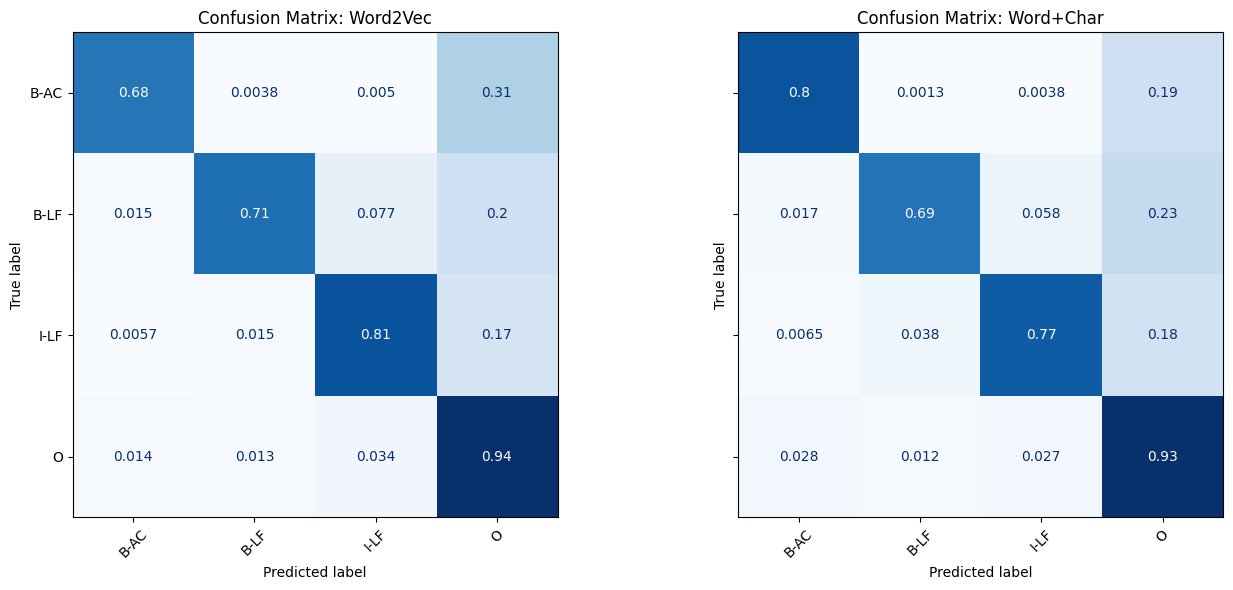

In [443]:
predictions_w2v = collect_predictions(model_w2v, test_loader, id2tag)
predictions_combined = collect_predictions(model_combined, test_loader, id2tag)

tag_list = sorted(set(tag for preds in [predictions_w2v, predictions_combined]
                      for _, p, t in preds for tag in p + t))

compare_ner_confusion_matrices(predictions_w2v, predictions_combined, tag_list, labels=("Word2Vec", "Word+Char"))


In [444]:
from collections import Counter

def get_top_confusions(predictions, top_k=10, exclude_correct=True):
    confusion_counts = Counter()

    for _, pred_tags, true_tags in predictions:
        for pred, true in zip(pred_tags, true_tags):
            if exclude_correct and pred == true:
                continue
            confusion_counts[(true, pred)] += 1

    most_common = confusion_counts.most_common(top_k)
    print(f"\nTop {top_k} Tag Confusions:\n")
    for (true, pred), count in most_common:
        print(f"True: {true:<6} → Pred: {pred:<6} | Count: {count}")


In [445]:
print("Word2Vec Confusions:")
get_top_confusions(predictions_w2v)

print("Word+Char Confusions:")
get_top_confusions(predictions_combined)


Word2Vec Confusions:

Top 10 Tag Confusions:

True: O      → Pred: I-LF   | Count: 263
True: B-AC   → Pred: O      | Count: 243
True: I-LF   → Pred: O      | Count: 204
True: O      → Pred: B-AC   | Count: 108
True: O      → Pred: B-LF   | Count: 102
True: B-LF   → Pred: O      | Count: 94
True: B-LF   → Pred: I-LF   | Count: 37
True: I-LF   → Pred: B-LF   | Count: 18
True: B-LF   → Pred: B-AC   | Count: 7
True: I-LF   → Pred: B-AC   | Count: 7
Word+Char Confusions:

Top 10 Tag Confusions:

True: I-LF   → Pred: O      | Count: 224
True: O      → Pred: B-AC   | Count: 215
True: O      → Pred: I-LF   | Count: 209
True: B-AC   → Pred: O      | Count: 152
True: B-LF   → Pred: O      | Count: 113
True: O      → Pred: B-LF   | Count: 95
True: I-LF   → Pred: B-LF   | Count: 46
True: B-LF   → Pred: I-LF   | Count: 28
True: B-LF   → Pred: B-AC   | Count: 8
True: I-LF   → Pred: B-AC   | Count: 8


In [446]:
id_to_token = {v: k for k, v in word_vocab.items()}

In [447]:
from collections import Counter

def get_most_missed_tokens(predictions, target_tags={"B-AC", "I-AC", "B-LF", "I-LF"}, top_k=20):
    missed = Counter()
    
    for tokens, pred_tags, true_tags in predictions:
        for word, pred, true in zip(tokens, pred_tags, true_tags):
            if true in target_tags and pred != true:
                missed[word] += 1
    
    print(f"\nTop {top_k} most frequently misclassified tokens (FN):\n")
    for token, count in missed.most_common(top_k):
        print(f"{token:<20} | Missed: {count}")


predictions_w2v = collect_predictions(model_w2v, test_loader, id2tag, id_to_token)
get_most_missed_tokens(predictions_w2v)

predictions_combined = collect_predictions(model_combined, test_loader, id2tag, id_to_token)
get_most_missed_tokens(predictions_combined)



Top 20 most frequently misclassified tokens (FN):

<UNK>                | Missed: 233
-                    | Missed: 42
and                  | Missed: 13
of                   | Missed: 9
,                    | Missed: 8
D                    | Missed: 5
FPG                  | Missed: 4
overweight           | Missed: 3
or                   | Missed: 3
obesity              | Missed: 3
6                    | Missed: 3
to                   | Missed: 3
Scale                | Missed: 3
Edition              | Missed: 3
for                  | Missed: 3
protein              | Missed: 3
rich                 | Missed: 3
ACC                  | Missed: 3
S                    | Missed: 3
Australian           | Missed: 3

Top 20 most frequently misclassified tokens (FN):

<UNK>                | Missed: 201
-                    | Missed: 31
and                  | Missed: 13
of                   | Missed: 10
,                    | Missed: 8
Ginir                | Missed: 5
/                    | Missed